## Image Registration using Enhanced Correlation Coefficient (ECC) Maximization

Image registration after applying some binary thresholding. 

In [15]:
import numpy as np
import cv2
from skimage.external import tifffile as tiff
from skimage.util import img_as_float
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_li
from skimage.transform import rescale
from skimage.transform import warp, AffineTransform, resize
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


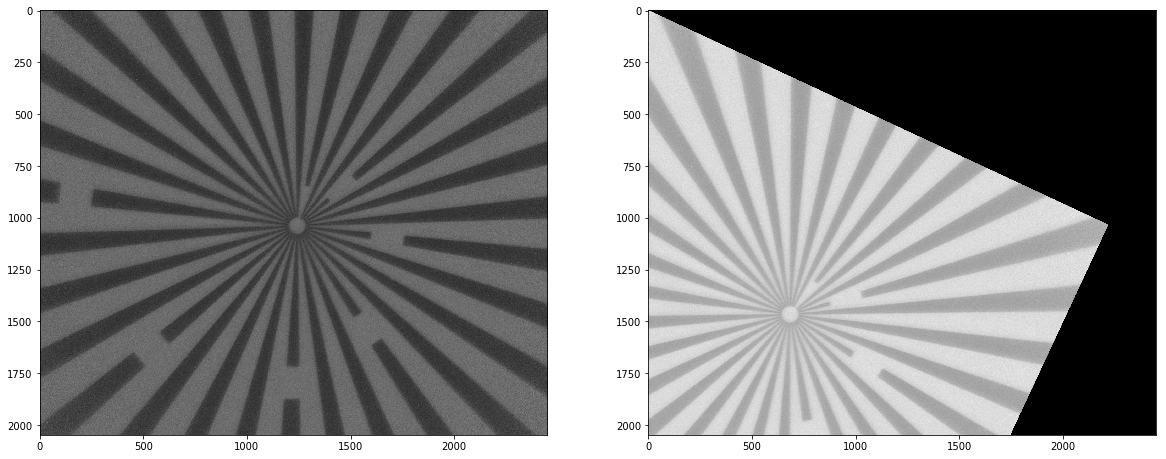

In [16]:
samples = ['../samples/rot_0.tif', 
           '../samples/rot_180.tif',
           '../samples/faked_rot_0_tilted_5.3deg.tif',
           '../samples/faked_rot_180.tif']

img0deg = img_as_float(tiff.imread(samples[0]))

tform = AffineTransform(rotation=25 *  np.pi/180)
img1deg = warp(img0deg, tform.inverse, output_shape=(img0deg.shape[0], img0deg.shape[1]))

f, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(img0deg, cmap='gray')
ax[1].imshow(img1deg, cmap='gray')

plt.show()


In [12]:
def preProcess(image, rs=0.3):
    tmp = rescale(image, rs, mode='reflect')
    tmp = rescale_intensity(tmp)
    
    thresh = threshold_li(tmp)
    binary = tmp > thresh
    result = np.zeros_like(binary, dtype=np.uint8)
    result[~binary] = 255
    
    return result

def computeRotation(img0, img1):
    sz = img0.shape
    warp_mode = cv2.MOTION_AFFINE

    warp_matrix = np.eye(2, 3, dtype=np.float32)

    number_of_iterations = 5000
    termination_eps = 1e-10

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (img0, img1, warp_matrix, warp_mode, criteria)

    sin = warp_matrix[0, 1]
    cos = warp_matrix[0, 0]
    
    degs = np.arctan2(sin, cos) * 180.0 / np.pi
    
    return degs

[[ 0.          0.41602067  0.43927649 ...,  0.24806202  0.28165375
   0.32213609]
 [ 0.4332472   0.41257537  0.46770026 ...,  0.28079242  0.3126615
   0.30146425]
 [ 0.40568475  0.41946598  0.41429802 ...,  0.26873385  0.23858742
   0.2540913 ]
 ..., 
 [ 0.26528854  0.29198966  0.2704565  ...,  0.40826873  0.46339363
   0.4461671 ]
 [ 0.30577089  0.31869078  0.28768303 ...,  0.42721792  0.34108527
   0.45822567]
 [ 0.28509905  0.31438415  0.31093885 ...,  0.4203273   0.42807924
   0.40654608]]
[[ 0.42739009  0.46767016  0.42739009 ...,  0.          0.          0.        ]
 [ 0.8345077   0.86075216  1.         ...,  0.          0.          0.        ]
 [ 0.85057157  0.87287371  0.88821637 ...,  0.          0.          0.        ]
 ..., 
 [ 0.67762721  0.64826627  0.64548427 ...,  0.          0.          0.        ]
 [ 0.66231365  0.63568893  0.63209142 ...,  0.          0.          0.        ]
 [ 0.66640075  0.6390579   0.64613356 ...,  0.          0.          0.        ]]


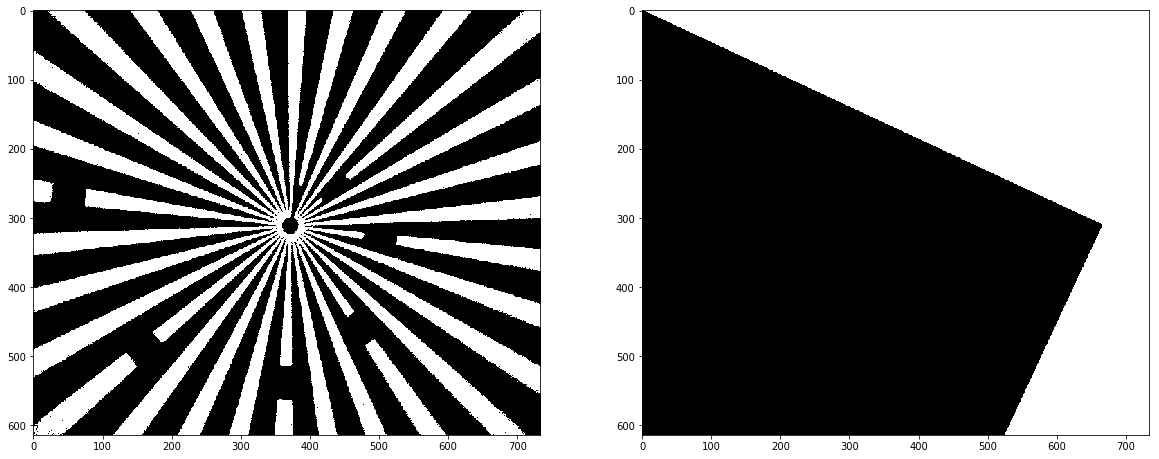

In [13]:
img0 = rescale_intensity(img0deg)
img1 = rescale_intensity(img1deg)

print (img0)
print (img1)

img0 = preProcess(img0deg)
img1 = preProcess(img1deg)

f, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(img0, cmap='gray')
ax[1].imshow(img1, cmap='gray')

In [ ]:
img0 = rescale(img0deg, 0.3, mode='reflect')
img1 = rescale(img180deg, 0.3, mode='reflect')

img0 = img0.astype(np.float32)
img1 = img1.astype(np.float32)

f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img0, cmap='gray')
ax[1].imshow(img1, cmap='gray')

plt.show()

In [ ]:
print (computeRotation(img1, img0))